In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from scipy.stats import zscore
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

tf.test.gpu_device_name()

2022-12-25 08:42:27.946113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 08:42:28.710567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-25 08:42:28.710666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-25 08:42:28.710672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

'/device:GPU:0'

2022-12-25 08:42:29.771974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:29.780025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:29.780235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:30.308725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:30.308921: I tensorflow/compiler/xla/stream_executo

In [2]:
train  = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')

df = pd.concat([train,test]).drop(['id', 'label'], axis=1)

In [3]:
NOMINAL_COLS = ['proto', 'service', 'state']
BINARY_COLS = ['is_sm_ips_ports', 'is_ftp_login']

for name in df.columns:
    if name == "attack_cat" or name in NOMINAL_COLS or name in BINARY_COLS:
        pass
    else:
        df[name] = zscore(df[name])

for name in NOMINAL_COLS:
    df = pd.concat([df, pd.get_dummies(df[name], prefix=name)],axis=1)
    df.drop(name,axis=1,inplace=True)

In [4]:
x = df.drop(['attack_cat'], axis=1).values

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

dummies = pd.get_dummies(df['attack_cat'])
attack_cat_list = list(dummies.columns)
y = dummies.values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred):
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, average='macro')
    pre = metrics.precision_score(y_truth, y_pred, average='macro')
    f1s = metrics.f1_score(y_truth, y_pred, average='macro')

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,10))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=attack_cat_list, yticklabels=attack_cat_list)

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

In [7]:
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=5,
    mode='auto',
    restore_best_weights=True
)

2022-12-25 08:42:35.844928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:35.845334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:35.845773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:35.847201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 08:42:35.847726: I tensorflow/compiler/xla/stream_executo

In [8]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[monitor],
    epochs=100
)

Epoch 1/100


2022-12-25 08:42:37.635041: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fde9c01e8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-25 08:42:37.635073: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2022-12-25 08:42:37.656467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-25 08:42:37.916653: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6442/6442 [==============================] - 24s 3ms/step - loss: 0.6039 - accuracy: 0.7576 - val_loss: 0.5473 - val_accuracy: 0.7791
Epoch 2/100
6442/6442 [==============================] - 21s 3ms/step - loss: 0.5368 - accuracy: 0.7831 - val_loss: 0.5243 - val_accuracy: 0.7879
Epoch 3/100
6442/6442 [==============================] - 21s 3ms/step - loss: 0.5112 - accuracy: 0.7928 - val_loss: 0.5197 - val_accuracy: 0.7905
Epoch 4/100
6442/6442 [==============================] - 21s 3ms/step - loss: 0.5002 - accuracy: 0.7972 - val_loss: 0.4944 - val_accuracy: 0.8005
Epoch 5/100
6442/6442 [==============================] - 21s 3ms/step - loss: 0.4921 - accuracy: 0.8008 - val_loss: 0.4892 - val_accuracy: 0.7987
Epoch 6/100
6442/6442 [==============================] - 21s 3ms/step - loss: 0.4868 - accuracy: 0.8027 - val_loss: 0.4843 - val_accuracy: 0.8048
Epoch 7/100
6442/6442 [==============================] - 21s 3ms/step - loss: 0.4810 - accuracy: 0.8049 - val_loss: 0.4765 - val_accurac

1611/1611 [==============================] - 2s 1ms/step


Accuracy     0.817250
Recall       0.483023
Precision    0.763754
F1-score     0.490729
Name: Keras, dtype: float64

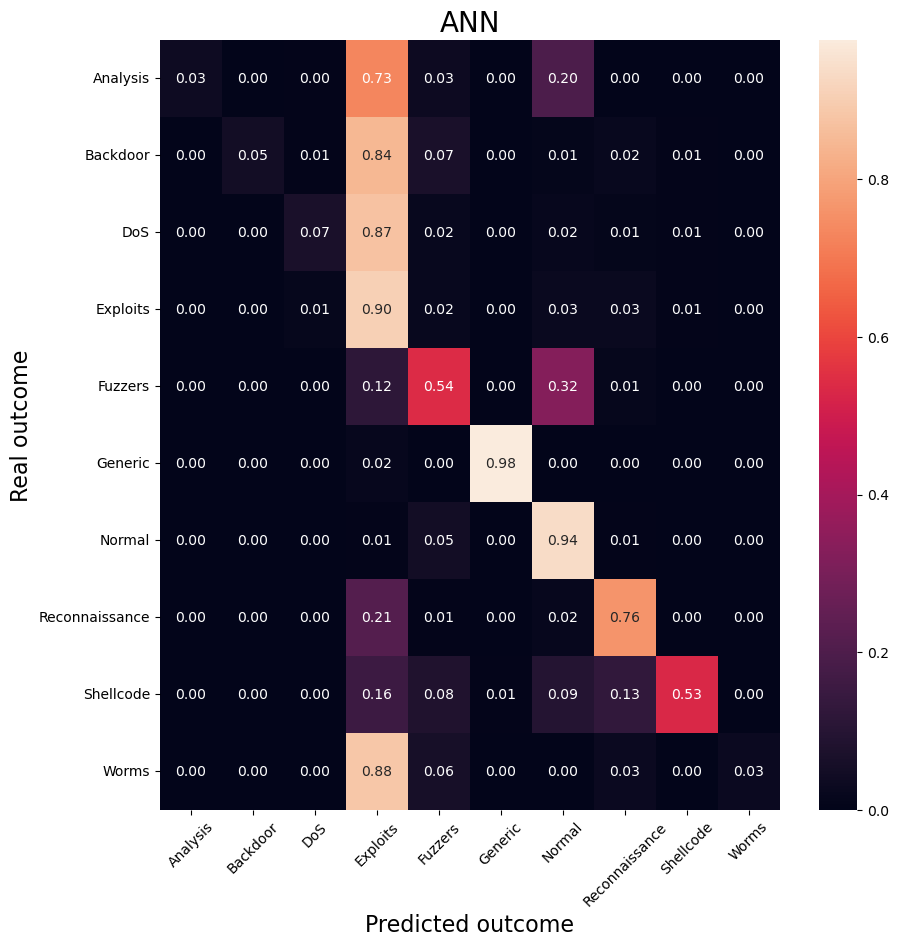

In [9]:
y_pred = model.predict(x_test)

getMetrics(f'Keras', np.argmax(y_test, axis=1), np.argmax(y_pred,axis=1))
getCM('ANN', np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [10]:
model.save("./models/KER1.h5")